# Import Library

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input, GRU
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Data Scraping

In [ ]:
# List ticker untuk saham 10 perusahaan Indonesia
tickers = ['BBCA.JK', 'BYAN.JK', 'TPIA.JK', 'BBRI.JK', 'BMRI.JK', 'DSSA.JK', 'TLKM.JK', 'ASII.JK', 'BBNI.JK', 'ICBP.JK']

# Download data harga penutupan (adjusted close) untuk setiap perusahaan dengan interval 1 hari
stock_close_datas = {}
stock_open_datas = {}
stock_high_datas = {}
stock_low_datas = {}
stock_volume_datas = {}
for ticker in tickers:
  df = yf.download(ticker, start='2018-01-01', end='2025-05-28', interval='1d')
  stock_open_datas[ticker] = df['Open']
  stock_high_datas[ticker] = df['High']
  stock_low_datas[ticker] = df['Low']
  stock_volume_datas[ticker] = df['Volume']
  stock_close_datas[ticker] = df['Close']

# Gabung semua jadi 1 dataframe
df_all = pd.concat(stock_close_datas, axis=1)
df_all.columns = tickers

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
df_all

,BBCA.JK,BYAN.JK,TPIA.JK,BBRI.JK,BMRI.JK,DSSA.JK,TLKM.JK,ASII.JK,BBNI.JK,ICBP.JK
Date,,,,,,,,,,
2018-01-01,3723.926514,711.824585,1457.917603,2289.992432,2592.609863,1390.0,3430.840088,5383.928711,3732.603516,7525.143066
2018-01-02,3723.926514,718.539856,1439.693848,2283.701416,2543.998535,1410.0,3407.658936,5319.062500,3685.474854,7694.248535
2018-01-03,3723.926514,718.539856,1403.245605,2271.119141,2495.387451,1390.0,3268.570801,5221.762207,3553.514648,7694.248535
2018-01-04,3779.189941,711.824585,1348.573975,2233.372314,2535.896484,1390.0,3260.843750,5335.278320,3544.088379,7715.386230
2018-01-05,3783.441162,715.182190,1385.021851,2258.536865,2535.896484,1390.0,3307.206543,5383.928711,3506.385742,7842.215332
...,...,...,...,...,...,...,...,...,...,...
2025-05-21,9700.000000,19950.000000,9500.000000,4260.000000,5450.000000,50825.0,2750.000000,4670.000000,4520.000000,10825.000000
2025-05-22,9650.000000,19950.000000,9525.000000,4300.000000,5450.000000,51800.0,2800.000000,4630.000000,4470.000000,10800.000000
2025-05-23,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000


# Data Preprocessing

## Menangani Missing Value

In [ ]:
df_all.isnull().sum()

,0
BBCA.JK,0
BYAN.JK,0
TPIA.JK,0
BBRI.JK,0
BMRI.JK,0
DSSA.JK,0
TLKM.JK,1
ASII.JK,1
BBNI.JK,0
ICBP.JK,1


In [ ]:
# Melihat baris yang bernilai null
df_all[df_all.isnull().any(axis=1)]

,BBCA.JK,BYAN.JK,TPIA.JK,BBRI.JK,BMRI.JK,DSSA.JK,TLKM.JK,ASII.JK,BBNI.JK,ICBP.JK
Date,,,,,,,,,,
2019-06-19,5152.052734,1144.98999,1209.519775,2880.275879,2881.316895,1450.0,NaN,NaN,3534.166748,NaN


Melakukan Forward fill untuk mengisi data yang hilang pada `TLKM.JK`, `ASII.JK`, dan `ICBP.JK`

In [ ]:
df_all_ffil = df_all.ffill()
display(df_all_ffil.loc["2019-06-18"])
display(df_all_ffil.loc["2019-06-19"])

,2019-06-18
BBCA.JK,5117.358398
BYAN.JK,1152.101562
TPIA.JK,1202.114258
BBRI.JK,2860.134277
BMRI.JK,2836.155273
DSSA.JK,1450.000000
TLKM.JK,3145.500977
ASII.JK,5101.784180
BBNI.JK,3464.674316
ICBP.JK,9077.743164


,2019-06-19
BBCA.JK,5152.052734
BYAN.JK,1144.989990
TPIA.JK,1209.519775
BBRI.JK,2880.275879
BMRI.JK,2881.316895
DSSA.JK,1450.000000
TLKM.JK,3145.500977
ASII.JK,5101.784180
BBNI.JK,3534.166748
ICBP.JK,9077.743164


In [ ]:
df_all_ffil.shape

(1820, 10)

In [ ]:
df_all_ffil.isnull().sum()

,0
BBCA.JK,0
BYAN.JK,0
TPIA.JK,0
BBRI.JK,0
BMRI.JK,0
DSSA.JK,0
TLKM.JK,0
ASII.JK,0
BBNI.JK,0
ICBP.JK,0


## Menangani Tanggal yang Terlewat dengan Forward Fill

Dilakukan Pengecekan terhadap berapa banyak hari yang tidak terdapat dalam data

In [ ]:
full_date_range = pd.date_range(start=df_all_ffil.index.min(), end=df_all_ffil.index.max(), freq='D')
df_all_ffil.index = pd.to_datetime(df_all_ffil.index)

existing_dates = df_all_ffil.index.unique()

existing_dates_index = pd.DatetimeIndex(existing_dates)

missing_dates = full_date_range.difference(existing_dates_index)
print(f"Jumlah tanggal yang hilang: {missing_dates.size}")

Jumlah tanggal yang hilang: 884


Melakukan Forward Fill untuk mengisi tanggal yang hilang dengan cara menyebarkan data nilai terakhir yang diketahui ke depan hingga nilai berikutnya yang tidak hilang

In [ ]:
df_all_ffil = df_all_ffil.reindex(full_date_range).ffill()
df_all_ffil.index.name = 'Date'
df_all_ffil

,BBCA.JK,BYAN.JK,TPIA.JK,BBRI.JK,BMRI.JK,DSSA.JK,TLKM.JK,ASII.JK,BBNI.JK,ICBP.JK
Date,,,,,,,,,,
2018-01-01,3723.926514,711.824585,1457.917603,2289.992432,2592.609863,1390.0,3430.840088,5383.928711,3732.603516,7525.143066
2018-01-02,3723.926514,718.539856,1439.693848,2283.701416,2543.998535,1410.0,3407.658936,5319.062500,3685.474854,7694.248535
2018-01-03,3723.926514,718.539856,1403.245605,2271.119141,2495.387451,1390.0,3268.570801,5221.762207,3553.514648,7694.248535
2018-01-04,3779.189941,711.824585,1348.573975,2233.372314,2535.896484,1390.0,3260.843750,5335.278320,3544.088379,7715.386230
2018-01-05,3783.441162,715.182190,1385.021851,2258.536865,2535.896484,1390.0,3307.206543,5383.928711,3506.385742,7842.215332
...,...,...,...,...,...,...,...,...,...,...
2025-05-23,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2025-05-24,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2025-05-25,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000


Melakukan pengecekan apakah tanggal yang hilang sudah berhasil diisi semuanya

In [ ]:
full_date_range = pd.date_range(start=df_all_ffil.index.min(), end=df_all_ffil.index.max(), freq='D')
df_all_ffil.index = pd.to_datetime(df_all_ffil.index)

existing_dates = df_all_ffil.index.unique()

existing_dates_index = pd.DatetimeIndex(existing_dates)

missing_dates = full_date_range.difference(existing_dates_index)
print(f"Jumlah tanggal yang hilang: {missing_dates.size}")

Jumlah tanggal yang hilang: 0


## Mengganti Nama Kolom

In [ ]:
df_all_ffil.columns = df_all_ffil.columns.str.replace('.JK', '', regex=False)
df_all_ffil

,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
Date,,,,,,,,,,
2018-01-01,3723.926514,711.824585,1457.917603,2289.992432,2592.609863,1390.0,3430.840088,5383.928711,3732.603516,7525.143066
2018-01-02,3723.926514,718.539856,1439.693848,2283.701416,2543.998535,1410.0,3407.658936,5319.062500,3685.474854,7694.248535
2018-01-03,3723.926514,718.539856,1403.245605,2271.119141,2495.387451,1390.0,3268.570801,5221.762207,3553.514648,7694.248535
2018-01-04,3779.189941,711.824585,1348.573975,2233.372314,2535.896484,1390.0,3260.843750,5335.278320,3544.088379,7715.386230
2018-01-05,3783.441162,715.182190,1385.021851,2258.536865,2535.896484,1390.0,3307.206543,5383.928711,3506.385742,7842.215332
...,...,...,...,...,...,...,...,...,...,...
2025-05-23,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2025-05-24,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2025-05-25,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000


## Menambah Fitur Tanggal

Dilakukan pengubahan data tanggal dari index menjadi kolom date

In [ ]:
df_all_ffil = df_all_ffil.reset_index()
df_all_ffil

,Date,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
0,2018-01-01,3723.926514,711.824585,1457.917603,2289.992432,2592.609863,1390.0,3430.840088,5383.928711,3732.603516,7525.143066
1,2018-01-02,3723.926514,718.539856,1439.693848,2283.701416,2543.998535,1410.0,3407.658936,5319.062500,3685.474854,7694.248535
2,2018-01-03,3723.926514,718.539856,1403.245605,2271.119141,2495.387451,1390.0,3268.570801,5221.762207,3553.514648,7694.248535
3,2018-01-04,3779.189941,711.824585,1348.573975,2233.372314,2535.896484,1390.0,3260.843750,5335.278320,3544.088379,7715.386230
4,2018-01-05,3783.441162,715.182190,1385.021851,2258.536865,2535.896484,1390.0,3307.206543,5383.928711,3506.385742,7842.215332
...,...,...,...,...,...,...,...,...,...,...,...
2699,2025-05-23,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2700,2025-05-24,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2701,2025-05-25,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2702,2025-05-26,9625.000000,19975.000000,9750.000000,4320.000000,5475.000000,53900.0,2800.000000,4730.000000,4500.000000,11025.000000


## Menangani Duplikasi Data

In [ ]:
print("Jumlah duplikasi data:", df_all_ffil.duplicated().sum())

Jumlah duplikasi data: 0


## Mengurutkan data

Karena data yang dibutuhkan merupakan data time series, maka datanya harus berurutan berdasarkan waktu (Kolom `Date`)

In [ ]:
df_all_ffil = df_all_ffil.sort_values(by="Date", ascending=True)
df_all_ffil

,Date,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
0,2018-01-01,3723.926514,711.824585,1457.917603,2289.992432,2592.609863,1390.0,3430.840088,5383.928711,3732.603516,7525.143066
1,2018-01-02,3723.926514,718.539856,1439.693848,2283.701416,2543.998535,1410.0,3407.658936,5319.062500,3685.474854,7694.248535
2,2018-01-03,3723.926514,718.539856,1403.245605,2271.119141,2495.387451,1390.0,3268.570801,5221.762207,3553.514648,7694.248535
3,2018-01-04,3779.189941,711.824585,1348.573975,2233.372314,2535.896484,1390.0,3260.843750,5335.278320,3544.088379,7715.386230
4,2018-01-05,3783.441162,715.182190,1385.021851,2258.536865,2535.896484,1390.0,3307.206543,5383.928711,3506.385742,7842.215332
...,...,...,...,...,...,...,...,...,...,...,...
2699,2025-05-23,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2700,2025-05-24,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2701,2025-05-25,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2702,2025-05-26,9625.000000,19975.000000,9750.000000,4320.000000,5475.000000,53900.0,2800.000000,4730.000000,4500.000000,11025.000000


# Data Exploration

## Deskripsi Variabel

Setiap kolom berisi harga saham penutupan (adjusted close) dari top 20 emiten Indonesia

In [ ]:
df_all_ffil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2704 entries, 0 to 2703
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2704 non-null   datetime64[ns]
 1   BBCA    2704 non-null   float64       
 2   BYAN    2704 non-null   float64       
 3   TPIA    2704 non-null   float64       
 4   BBRI    2704 non-null   float64       
 5   BMRI    2704 non-null   float64       
 6   DSSA    2704 non-null   float64       
 7   TLKM    2704 non-null   float64       
 8   ASII    2704 non-null   float64       
 9   BBNI    2704 non-null   float64       
 10  ICBP    2704 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 232.5 KB


Terdapat nilai null pada beberapa kolom

In [ ]:
df_all_ffil.describe()

,Date,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
count,2704,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000
mean,2021-09-13 12:00:00,6647.044783,7464.078745,3075.294015,3323.686680,3496.613414,7859.921413,3136.352791,4521.508751,3383.968303,9258.538767
min,2018-01-01 00:00:00,3529.552490,587.591003,1093.920898,1513.757202,1411.886963,920.000000,2070.656250,2251.151611,1292.781372,6683.181152
25%,2019-11-07 18:00:00,5111.655762,1156.325195,1722.659424,2546.368835,2476.076660,1497.500000,2783.105957,4184.782959,2789.609131,8028.595215
50%,2021-09-13 12:00:00,6205.837158,1422.347656,2247.613892,3233.821167,2806.314453,2212.500000,3051.436523,4564.071777,3421.679932,9129.916016
75%,2023-07-21 06:00:00,8451.989258,17674.641113,2599.425293,3979.261169,4483.701050,5000.000000,3534.067383,4890.241211,3988.644043,10396.153320
max,2025-05-27 00:00:00,10570.414062,22388.601562,10625.000000,5763.100098,6769.004883,53900.000000,4295.701172,5738.723145,5460.848145,12800.000000
std,NaN,1897.875895,7963.274622,2358.763384,936.935357,1349.876992,12444.669658,468.294402,633.273794,899.857010,1393.909455


## Analisis Harga Saham Tiap Perusahaan

In [ ]:
dates = df_all_ffil['Date']
stocks = df_all_ffil.drop(columns='Date')

<Figure size 1400x600 with 0 Axes>

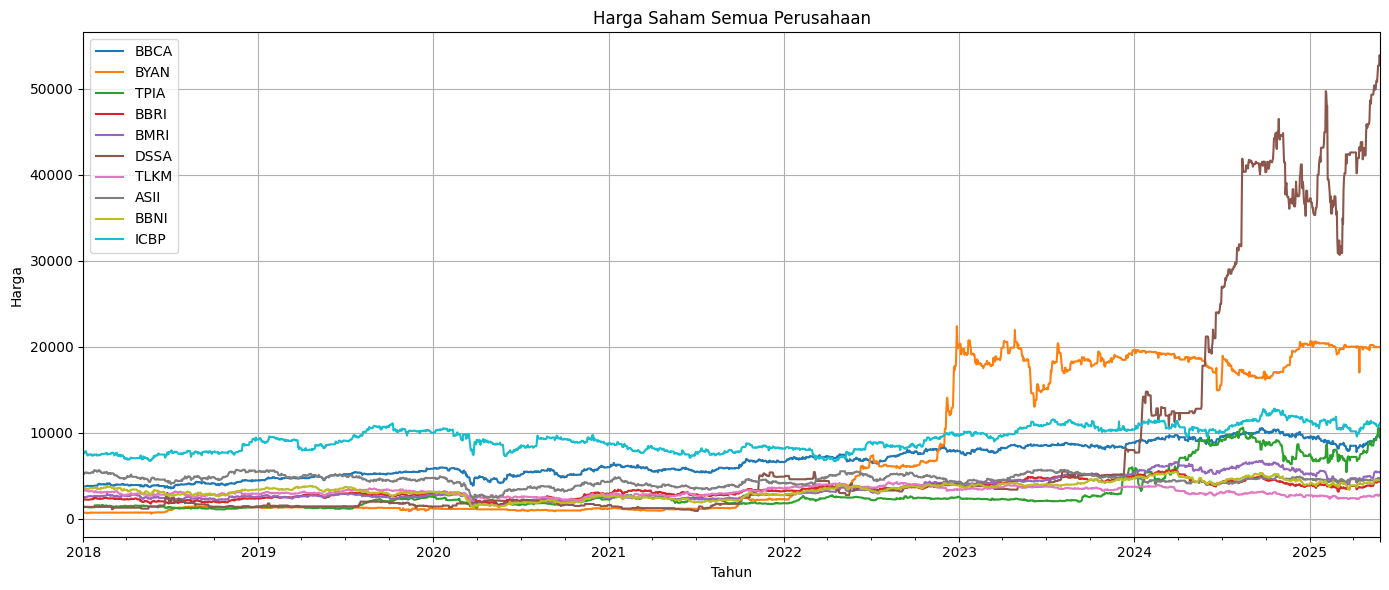

In [ ]:
plt.figure(figsize=(14, 6))
stocks.index = dates  # ubah dates jadi index
stocks.plot(figsize=(14, 6))
plt.ylabel("Harga")
plt.xlabel("Tahun")
plt.title("Harga Saham Semua Perusahaan")
plt.grid(True)
plt.tight_layout()
plt.show()

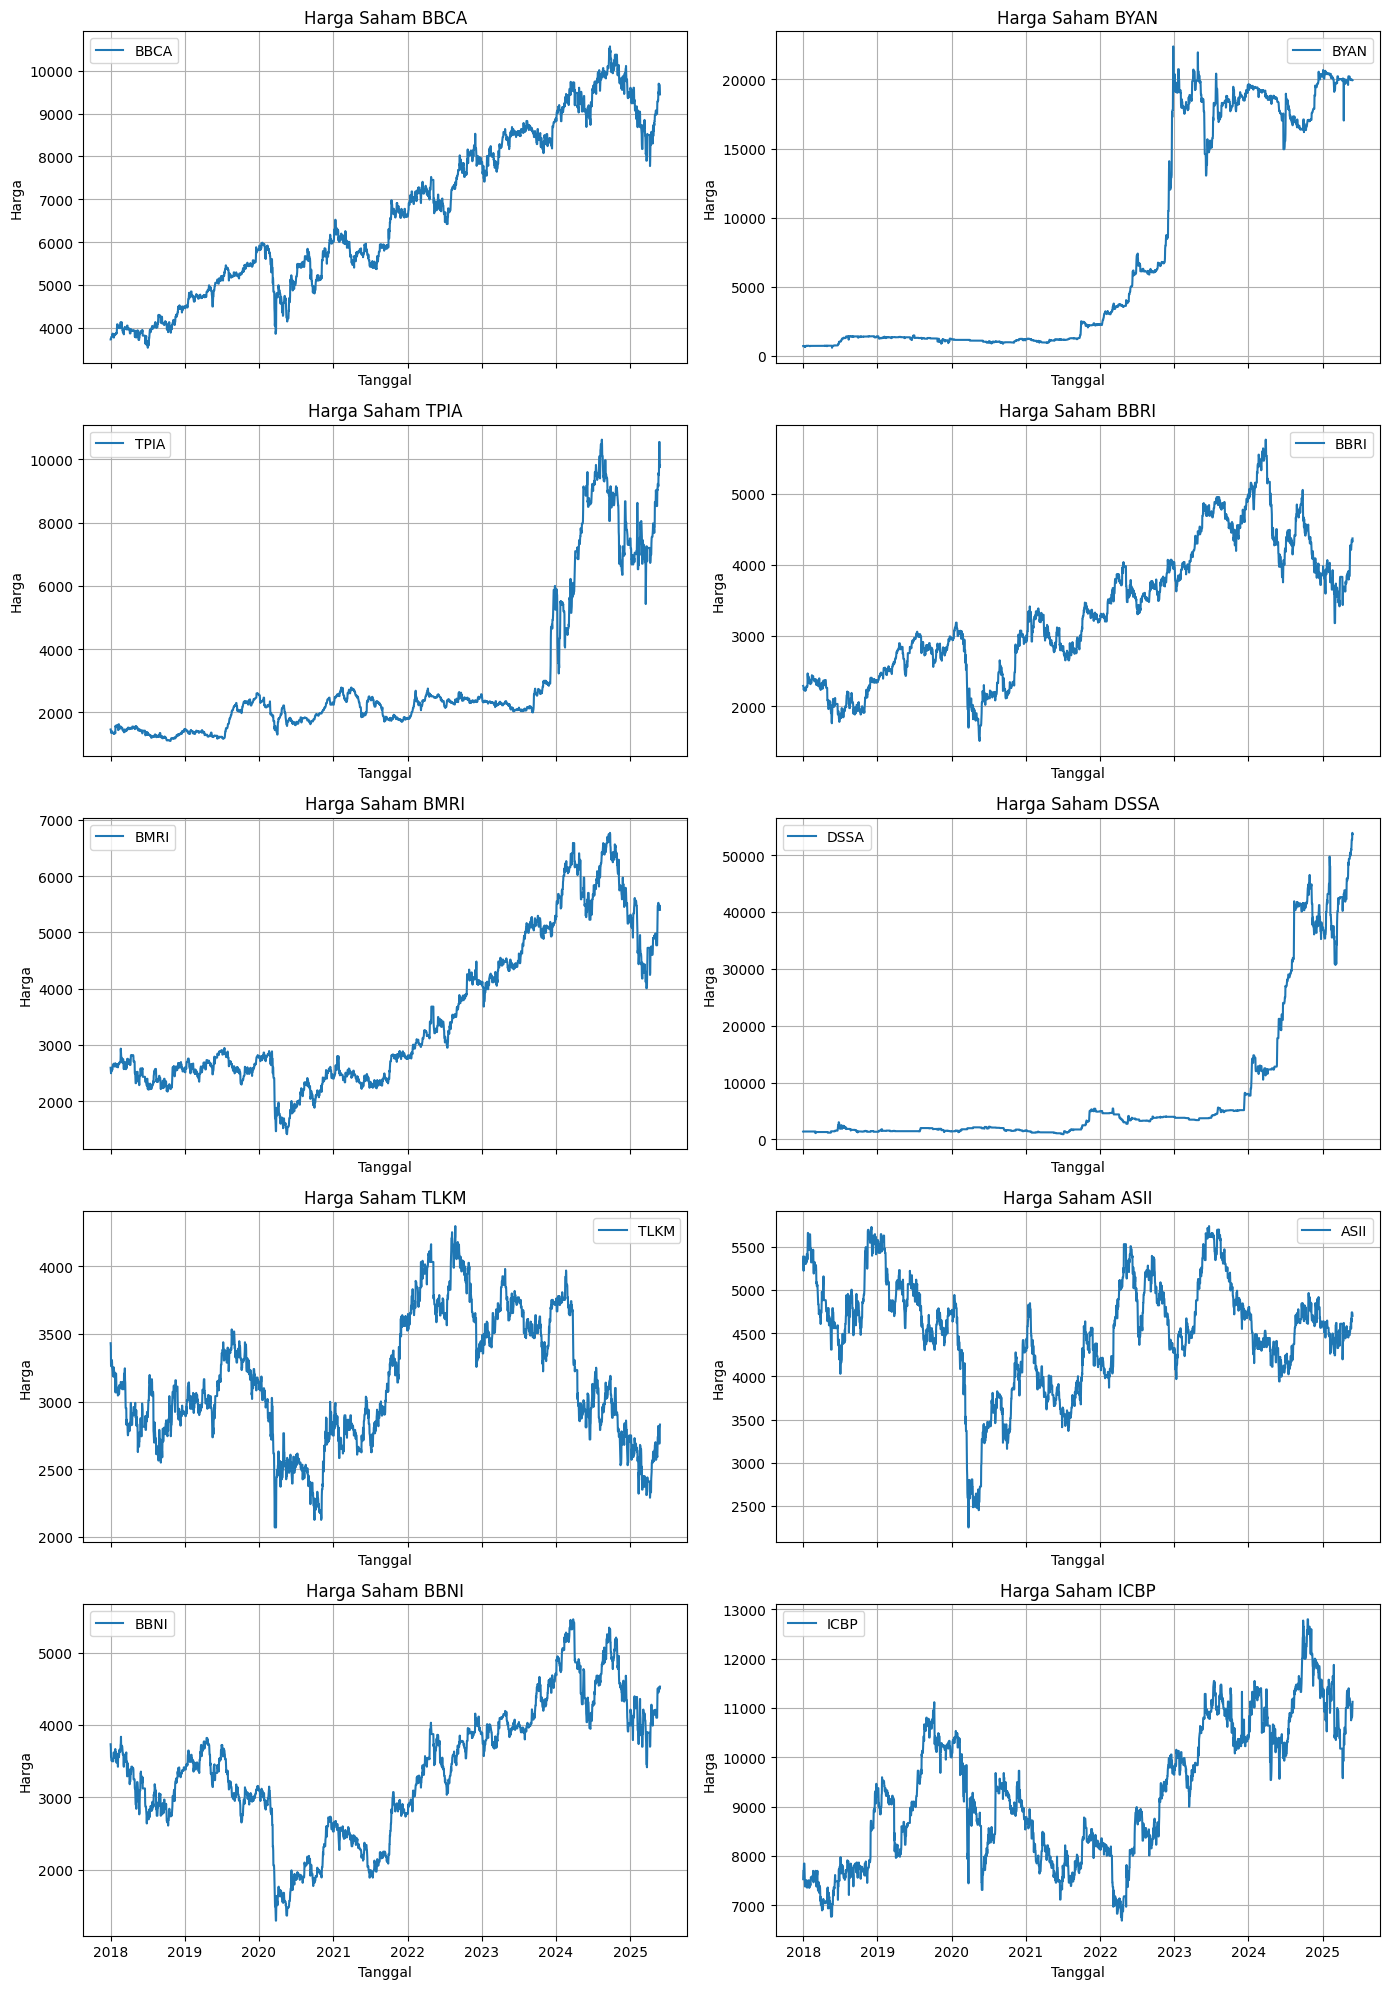

In [ ]:
num_stocks = len(stocks.columns)
cols = 2  # jumlah kolom subplot
rows = (num_stocks + cols - 1) // cols  # jumlah baris yang dibutuhkan

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()  # ubah axes jadi array datar agar mudah diakses

for i, stock in enumerate(stocks.columns):
    axes[i].plot(dates, stocks[stock], label=stock)
    axes[i].set_title(f"Harga Saham {stock}")
    axes[i].set_ylabel("Harga")
    axes[i].set_xlabel("Tanggal")
    axes[i].legend()
    axes[i].grid(True)

# Sembunyikan subplot kosong jika jumlah saham ganjil
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Korelasi Antar Saham

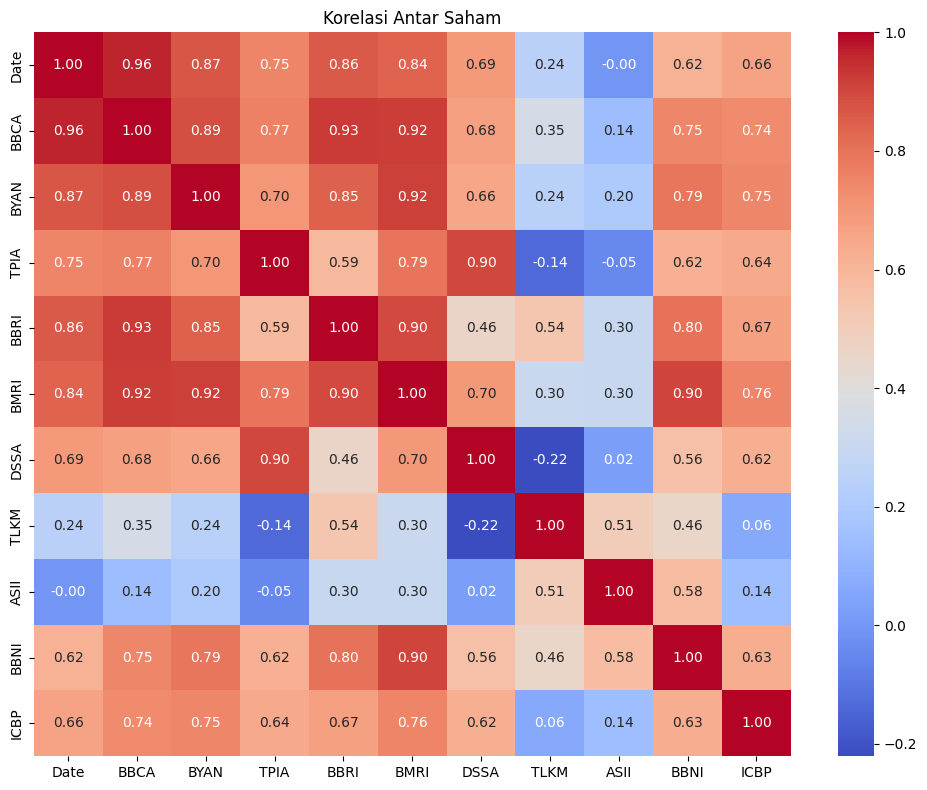

In [ ]:
plt.figure(figsize=(10, 8))
correlation_matrix = df_all_ffil.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasi Antar Saham")
plt.tight_layout()
plt.show()

# Data Preparation

## Simpan Data ke Format CSV

In [ ]:
# Saving data to csv
df_all_ffil.to_csv("stocks.csv", index=False)

## Standarisasi Data

In [ ]:
# Asumsikan df_all_ffil sudah tersedia
df = df_all_ffil.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Simpan nama saham
tickers = df.columns.tolist()

# Simpan hasil standarisasi
scalers = {ticker: StandardScaler() for ticker in tickers}
df_scaled = pd.DataFrame(index=df.index)

# Standarisasi per kolom
for ticker in tickers:
    df_scaled[ticker] = scalers[ticker].fit_transform(df[[ticker]])

## Windowing

In [ ]:
def create_sliding_window(data, window_size=30, horizon=1):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size + horizon - 1])
    return np.array(X), np.array(y)

## Splitting Data

In [ ]:
# Split rasio: 70% train, 15% eval, 15% test
train_ratio = 0.7
eval_ratio = 0.15

def split_data(data, window_size, horizon):
    X, y = create_sliding_window(data, window_size, horizon)
    n = len(X)
    train_end = int(n * train_ratio)
    eval_end = train_end + int(n * eval_ratio)

    return (X[:train_end], y[:train_end],
            X[train_end:eval_end], y[train_end:eval_end],
            X[eval_end:], y[eval_end:])

# Modeling

## BBCA

In [ ]:
window_size = 30
horizon = 1

data_bbca = df_scaled['BBCA'].values
X_train_bbca, y_train_bbca, X_val_bbca, y_val_bbca, X_test_bbca, y_test_bbca = split_data(data_bbca, window_size, horizon)

model_bbca = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(1)
])

model_bbca.compile(optimizer='adam', loss='mae', metrics=['mape'])

model_bbca.summary()
print("Model input shape:", model_bbca.input_shape)
print("Model output shape:", model_bbca.output_shape)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (None, 30, 1)
Model output shape: (None, 1)


In [ ]:
history_bbca = model_bbca.fit(X_train_bbca[..., np.newaxis], y_train_bbca,
              validation_data=(X_val_bbca[..., np.newaxis], y_val_bbca),
              epochs=40)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.1972 - mape: 53.0672 - val_loss: 0.1332 - val_mape: 11.5946
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0537 - mape: 53.4327 - val_loss: 0.0745 - val_mape: 6.5438
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0474 - mape: 43.1540 - val_loss: 0.0585 - val_mape: 5.2764
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 0.0454 - mape: 32.1376 - val_loss: 0.0729 - val_mape: 6.4445
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0423 - mape: 24.5872 - val_loss: 0.0762 - val_mape: 6.7928
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0411 - mape: 33.2388 - val_loss: 0.0507 - val_mape: 4.6141
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.0420 - mape: 28.4418 - val_loss: 0.0660 - val_mape: 5.8613
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0359 - mape: 23.2158 - val_loss: 0.0457 - val_mape: 4.3694
Epoch 9/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 

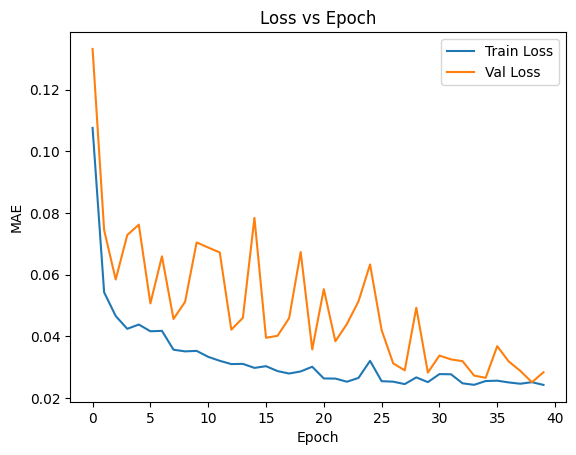

In [ ]:
plt.plot(history_bbca.history['loss'], label='Train Loss')
plt.plot(history_bbca.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [ ]:
y_pred_bbca = model_bbca.predict(X_test_bbca[..., np.newaxis]).flatten()
scaler_bbca = scalers['BBCA']
y_pred_unscaled_bbca = scaler_bbca.inverse_transform(y_pred_bbca.reshape(-1, 1)).flatten()
y_test_unscaled_bbca = scaler_bbca.inverse_transform(y_test_bbca.reshape(-1, 1)).flatten()

mae_bbca = mean_absolute_error(y_test_unscaled_bbca, y_pred_unscaled_bbca)
rmse_bbca = np.sqrt(mean_squared_error(y_test_unscaled_bbca, y_pred_unscaled_bbca))
mape_bbca = mean_absolute_percentage_error(y_test_unscaled_bbca, y_pred_unscaled_bbca) * 100

print('MAE Data Test BBCA : ', mae_bbca)
print('RMSE Data Test BBCA: ', rmse_bbca)
print('MAPE Data Test BBCA: ', mape_bbca)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
MAE Data Test BBCA :  96.25944496268657
RMSE Data Test BBCA:  132.159701257482
MAPE Data Test BBCA:  1.0282013722085226


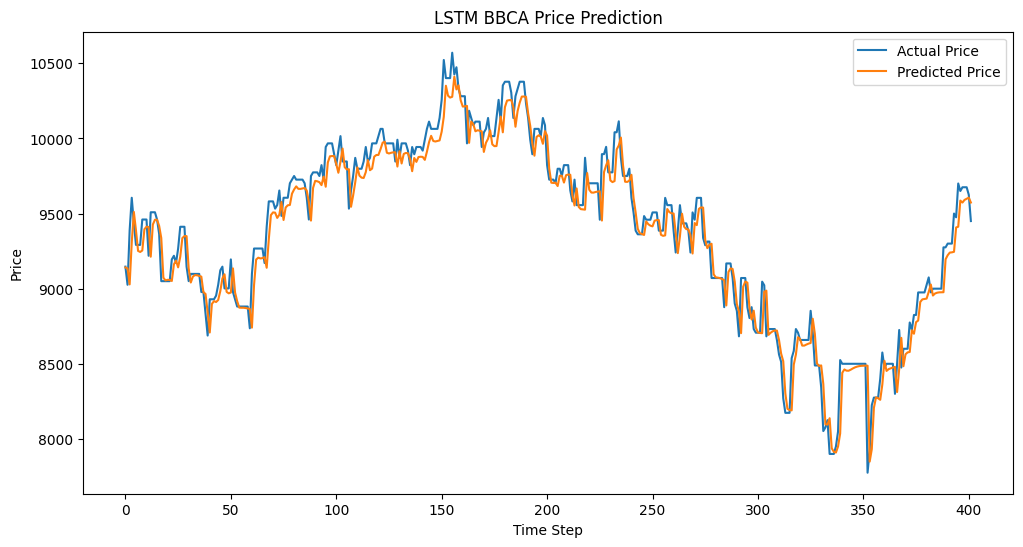

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled_bbca, label='Actual Price')
plt.plot(y_pred_unscaled_bbca, label='Predicted Price')
plt.title('LSTM BBCA Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
time_span = {'1d': 1, '1w': 7, '1m': 30, '3m': 90, '6m': 180}
recent_data_bbca = data_bbca[-365:]

pred_dict_bbca = {}
for label, steps in time_span.items():
    X = recent_data_bbca.copy()
    for _ in range(steps):
        x_input = X[-365:].reshape(1, 365, 1)
        next_pred = model_bbca.predict(x_input, verbose=0)[0, 0]
        X = np.append(X, next_pred)

    # Ambil nilai terakhir dan kembalikan ke skala asli
    unscaled_pred_bbca = scaler_bbca.inverse_transform([[X[-1]]])[0, 0]
    pred_dict_bbca[label] = float(unscaled_pred_bbca)

pred_dict_bbca

{'1d': 9438.43619214915,
 '1w': 9356.943991735096,
 '1m': 8985.969242543522,
 '3m': 8452.715166022266,
 '6m': 7999.226006875607}

## BYAN

In [ ]:
window_size = 30
horizon = 1

data_byan = df_scaled['BYAN'].values
X_train_byan, y_train_byan, X_val_byan, y_val_byan, X_test_byan, y_test_byan = split_data(data_byan, window_size, horizon)

model_byan = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1)
])

model_byan.compile(optimizer='adam', loss='mae', metrics=['mape'])

model_byan.summary()
print("Model input shape:", model_byan.input_shape)
print("Model output shape:", model_byan.output_shape)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (None, 30, 1)
Model output shape: (None, 1)


In [ ]:
history_byan = model_byan.fit(X_train_byan[..., np.newaxis], y_train_byan,
              validation_data=(X_val_byan[..., np.newaxis], y_val_byan),
              epochs=40)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.2720 - mape: 45.2239 - val_loss: 0.1152 - val_mape: 8.5269
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0211 - mape: 5.9253 - val_loss: 0.0689 - val_mape: 5.4614
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0180 - mape: 5.5319 - val_loss: 0.0974 - val_mape: 7.2202
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0194 - mape: 5.2972 - val_loss: 0.0545 - val_mape: 4.4872
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0236 - mape: 8.0340 - val_loss: 0.1092 - val_mape: 7.9738
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0218 - mape: 6.0444 - val_loss: 0.0639 - val_mape: 4.9412
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0168 - mape: 5.6378 - val_loss: 0.0537 - val_mape: 4.4333
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0196 - mape: 6.5190 - val_loss: 0.0492 - val_mape: 3.9798
Epoch 9/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/s

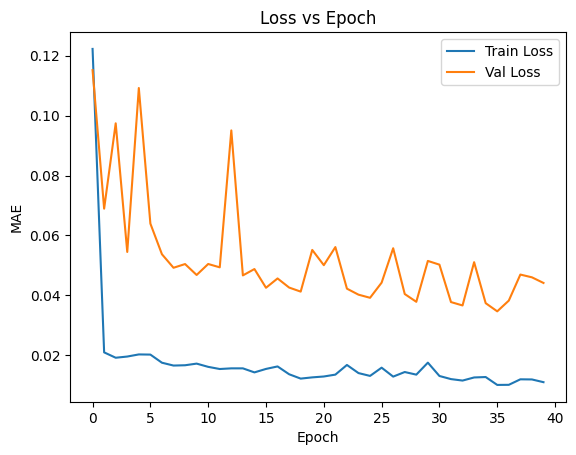

In [ ]:
plt.plot(history_byan.history['loss'], label='Train Loss')
plt.plot(history_byan.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [ ]:
y_pred_byan = model_byan.predict(X_test_byan[..., np.newaxis]).flatten()
scaler_byan = scalers['BYAN']
y_pred_unscaled_byan = scaler_byan.inverse_transform(y_pred_byan.reshape(-1, 1)).flatten()
y_test_unscaled_byan = scaler_byan.inverse_transform(y_test_byan.reshape(-1, 1)).flatten()

mae_byan = mean_absolute_error(y_test_unscaled_byan, y_pred_unscaled_byan)
rmse_byan = np.sqrt(mean_squared_error(y_test_unscaled_byan, y_pred_unscaled_byan))
mape_byan = mean_absolute_percentage_error(y_test_unscaled_byan, y_pred_unscaled_byan) * 100

print('MAE Data Test BYAN : ', mae_byan)
print('RMSE Data Test BYAN: ', rmse_byan)
print('MAPE Data Test BYAN: ', mape_byan)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
MAE Data Test BYAN :  371.50132880519277
RMSE Data Test BYAN:  485.8512544715429
MAPE Data Test BYAN:  1.9551232223878932


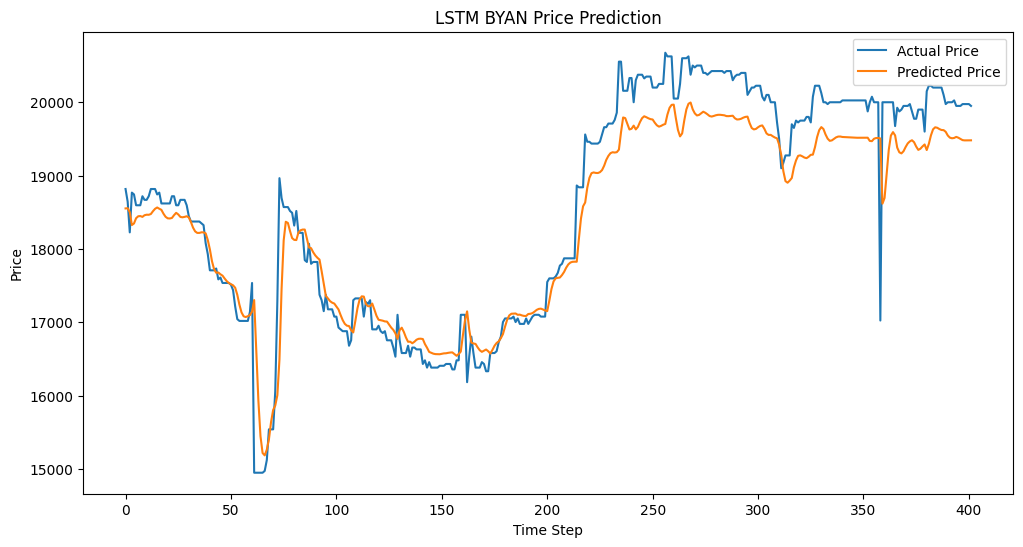

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled_byan, label='Actual Price')
plt.plot(y_pred_unscaled_byan, label='Predicted Price')
plt.title('LSTM BYAN Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
time_span = {'1d': 1, '1w': 7, '1m': 30, '3m': 90, '6m': 180}
recent_data_byan = data_byan[-365:]

pred_dict_byan = {}
for label, steps in time_span.items():
    X = recent_data_byan.copy()
    for _ in range(steps):
        x_input = X[-365:].reshape(1, 365, 1)
        next_pred = model_byan.predict(x_input, verbose=0)[0, 0]
        X = np.append(X, next_pred)

    # Ambil nilai terakhir dan kembalikan ke skala asli
    unscaled_pred_byan = scaler_byan.inverse_transform([[X[-1]]])[0, 0]
    pred_dict_byan[label] = float(unscaled_pred_byan)

pred_dict_byan

{'1d': 19458.740392443437,
 '1w': 18584.698882502995,
 '1m': 17448.663027530703,
 '3m': 17445.89634051993,
 '6m': 17444.30466500807}

## TPIA

In [ ]:
window_size = 30
horizon = 1

data_tpia = df_scaled['TPIA'].values
X_train_tpia, y_train_tpia, X_val_tpia, y_val_tpia, X_test_tpia, y_test_tpia = split_data(data_tpia, window_size, horizon)

model_tpia = Sequential([
    Input(shape=(window_size, 1)),
    GRU(128, return_sequences=True),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(1)
])

model_tpia.compile(optimizer='adam', loss='mae', metrics=['mape'])

model_tpia.summary()
print("Model input shape:", model_tpia.input_shape)
print("Model output shape:", model_tpia.output_shape)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,617 (342.25 KB)

 Trainable params: 87,617 (342.25 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (None, 30, 1)
Model output shape: (None, 1)


In [ ]:
history_tpia = model_tpia.fit(X_train_tpia[..., np.newaxis], y_train_tpia,
              validation_data=(X_val_tpia[..., np.newaxis], y_val_tpia),
              epochs=40)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 0.1276 - mape: 28.6475 - val_loss: 0.0605 - val_mape: 15.1204
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0412 - mape: 9.1286 - val_loss: 0.0519 - val_mape: 13.8242
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0369 - mape: 8.1570 - val_loss: 0.0697 - val_mape: 15.5144
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0377 - mape: 8.2308 - val_loss: 0.0557 - val_mape: 14.7245
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0343 - mape: 7.4854 - val_loss: 0.0520 - val_mape: 12.6164
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0306 - mape: 6.7936 - val_loss: 0.0725 - val_mape: 15.0858
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0311 - mape: 6.6013 - val_loss: 0.0590 - val_mape: 13.0160
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0305 - mape: 6.6931 - val_loss: 0.0621 - val_mape: 13.7008
Epoch 9/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3

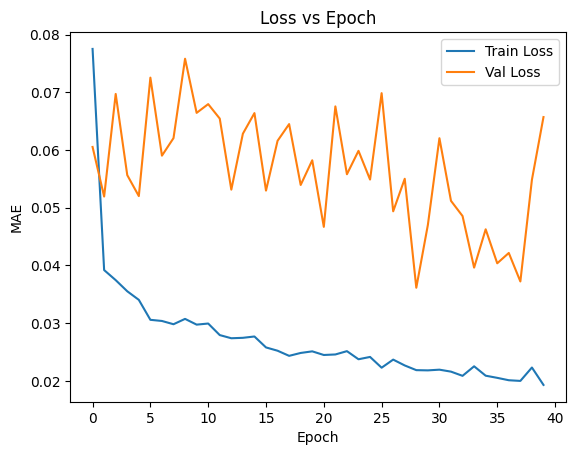

In [ ]:
plt.plot(history_tpia.history['loss'], label='Train Loss')
plt.plot(history_tpia.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [ ]:
y_pred_tpia = model_tpia.predict(X_test_tpia[..., np.newaxis]).flatten()
scaler_tpia = scalers['TPIA']
y_pred_unscaled_tpia = scaler_tpia.inverse_transform(y_pred_tpia.reshape(-1, 1)).flatten()
y_test_unscaled_tpia = scaler_tpia.inverse_transform(y_test_tpia.reshape(-1, 1)).flatten()

mae_tpia = mean_absolute_error(y_test_unscaled_tpia, y_pred_unscaled_tpia)
rmse_tpia = np.sqrt(mean_squared_error(y_test_unscaled_tpia, y_pred_unscaled_tpia))
mape_tpia = mean_absolute_percentage_error(y_test_unscaled_tpia, y_pred_unscaled_tpia) * 100

print('MAE Data Test TPIA : ', mae_tpia)
print('RMSE Data Test TPIA: ', rmse_tpia)
print('MAPE Data Test TPIA: ', mape_tpia)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
MAE Data Test TPIA :  961.133541277985
RMSE Data Test TPIA:  1050.131083787244
MAPE Data Test TPIA:  11.341672432324069


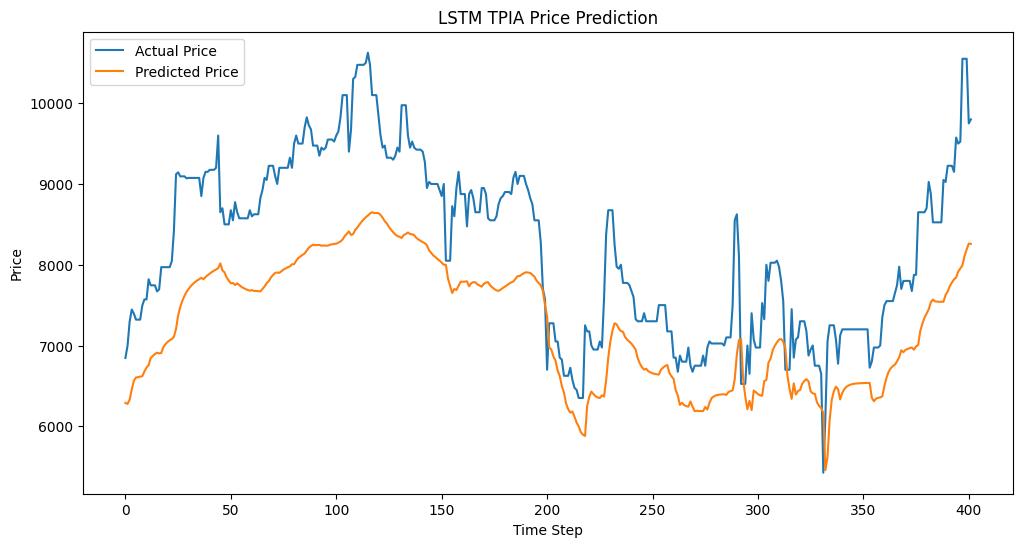

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled_tpia, label='Actual Price')
plt.plot(y_pred_unscaled_tpia, label='Predicted Price')
plt.title('LSTM TPIA Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
time_span = {'1d': 1, '1w': 7, '1m': 30, '3m': 90, '6m': 180}
recent_data_tpia = data_tpia[-365:]

pred_dict_tpia = {}
for label, steps in time_span.items():
    X = recent_data_tpia.copy()
    for _ in range(steps):
        x_input = X[-365:].reshape(1, 365, 1)
        next_pred = model_tpia.predict(x_input, verbose=0)[0, 0]
        X = np.append(X, next_pred)

    # Ambil nilai terakhir dan kembalikan ke skala asli
    unscaled_pred_tpia = scaler_tpia.inverse_transform([[X[-1]]])[0, 0]
    pred_dict_tpia[label] = float(unscaled_pred_tpia)

pred_dict_tpia

{'1d': 8242.148182222323,
 '1w': 7259.213104330729,
 '1m': 3062.9776524784133,
 '3m': 2602.984597640781,
 '6m': 2601.676092215882}

## BBRI

In [ ]:
window_size = 30
horizon = 1

data_bbri = df_scaled['BBRI'].values
X_train_bbri, y_train_bbri, X_val_bbri, y_val_bbri, X_test_bbri, y_test_bbri = split_data(data_bbri, window_size, horizon)

model_bbri = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1)
])

model_bbri.compile(optimizer='adam', loss='mae', metrics=['mape'])

model_bbri.summary()
print("Model input shape:", model_bbri.input_shape)
print("Model output shape:", model_bbri.output_shape)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (None, 30, 1)
Model output shape: (None, 1)


In [ ]:
history_bbri = model_bbri.fit(X_train_bbri[..., np.newaxis], y_train_bbri,
              validation_data=(X_val_bbri[..., np.newaxis], y_val_bbri),
              epochs=40)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.2374 - mape: 78.4081 - val_loss: 0.4938 - val_mape: 29.6992
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0730 - mape: 44.2964 - val_loss: 0.3218 - val_mape: 18.8851
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0679 - mape: 42.9229 - val_loss: 0.2833 - val_mape: 16.5126
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0662 - mape: 49.9266 - val_loss: 0.2379 - val_mape: 13.8180
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0615 - mape: 39.7667 - val_loss: 0.1948 - val_mape: 11.0487
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0568 - mape: 36.9203 - val_loss: 0.2544 - val_mape: 14.8727
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0591 - mape: 51.7824 - val_loss: 0.1783 - val_mape: 10.1998
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0534 - mape: 40.1487 - val_loss: 0.2092 - val_mape: 12.1680
Epoch 9/40
59/59 ━━━━━━━━━━━━━━━

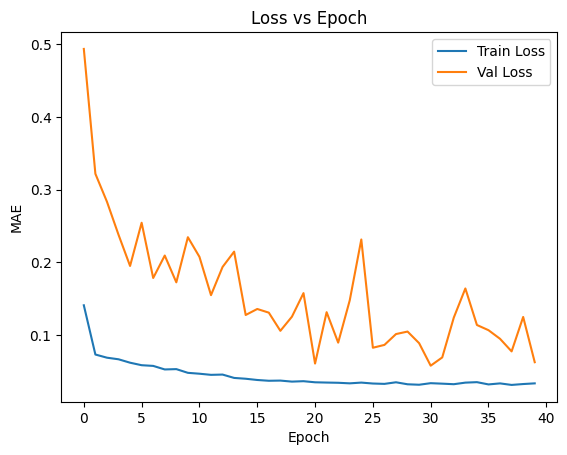

In [ ]:
plt.plot(history_bbri.history['loss'], label='Train Loss')
plt.plot(history_bbri.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [ ]:
y_pred_bbri = model_bbri.predict(X_test_bbri[..., np.newaxis]).flatten()
scaler_bbri = scalers['BBRI']
y_pred_unscaled_bbri = scaler_bbri.inverse_transform(y_pred_bbri.reshape(-1, 1)).flatten()
y_test_unscaled_bbri = scaler_bbri.inverse_transform(y_test_bbri.reshape(-1, 1)).flatten()

mae_bbri = mean_absolute_error(y_test_unscaled_bbri, y_pred_unscaled_bbri)
rmse_bbri = np.sqrt(mean_squared_error(y_test_unscaled_bbri, y_pred_unscaled_bbri))
mape_bbri = mean_absolute_percentage_error(y_test_unscaled_bbri, y_pred_unscaled_bbri) * 100

print('MAE Data Test BBRI : ', mae_bbri)
print('RMSE Data Test BBRI: ', rmse_bbri)
print('MAPE Data Test BBRI: ', mape_bbri)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
MAE Data Test BBRI :  47.60777715426772
RMSE Data Test BBRI:  73.34213070452351
MAPE Data Test BBRI:  1.1740044093406126


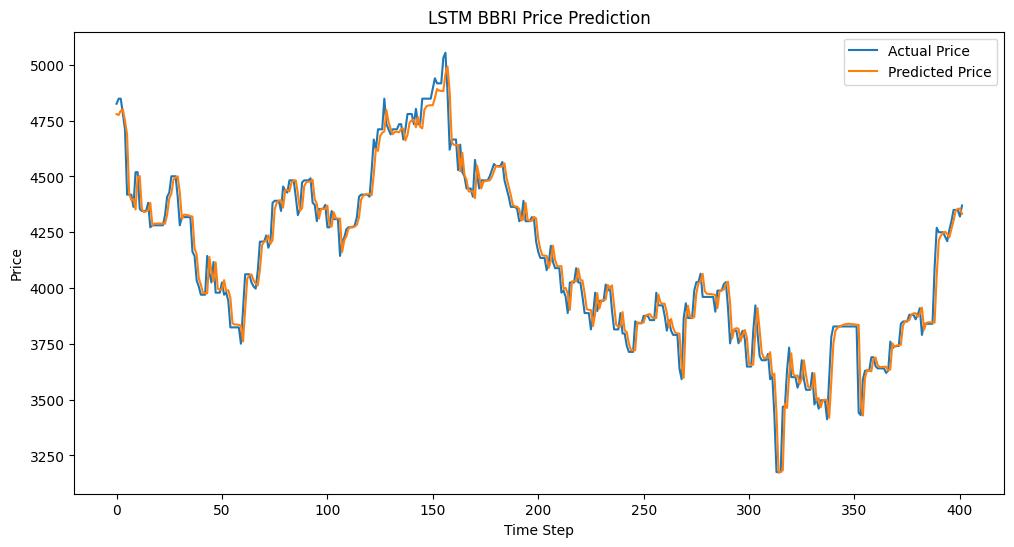

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled_bbri, label='Actual Price')
plt.plot(y_pred_unscaled_bbri, label='Predicted Price')
plt.title('LSTM BBRI Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
time_span = {'1d': 1, '1w': 7, '1m': 30, '3m': 90, '6m': 180}
recent_data_bbri = data_bbri[-365:]

pred_dict_bbri = {}
for label, steps in time_span.items():
    X = recent_data_bbri.copy()
    for _ in range(steps):
        x_input = X[-365:].reshape(1, 365, 1)
        next_pred = model_bbri.predict(x_input, verbose=0)[0, 0]
        X = np.append(X, next_pred)

    # Ambil nilai terakhir dan kembalikan ke skala asli
    unscaled_pred_bbri = scaler_bbri.inverse_transform([[X[-1]]])[0, 0]
    pred_dict_bbri[label] = float(unscaled_pred_bbri)

pred_dict_bbri

{'1d': 4367.883842470851,
 '1w': 4384.384869859399,
 '1m': 4419.593873536979,
 '3m': 4461.075981221269,
 '6m': 4464.659942057788}

## BMRI

In [ ]:
window_size = 30
horizon = 1

data_bmri = df_scaled['BMRI'].values
X_train_bmri, y_train_bmri, X_val_bmri, y_val_bmri, X_test_bmri, y_test_bmri = split_data(data_bmri, window_size, horizon)

model_bmri = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1)
])

model_bmri.compile(optimizer='adam', loss='mae', metrics=['mape'])

model_bmri.summary()
print("Model input shape:", model_bmri.input_shape)
print("Model output shape:", model_bmri.output_shape)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (None, 30, 1)
Model output shape: (None, 1)


In [ ]:
history_bmri = model_bmri.fit(X_train_bmri[..., np.newaxis], y_train_bmri,
              validation_data=(X_val_bmri[..., np.newaxis], y_val_bmri),
              epochs=40)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.1964 - mape: 94.3046 - val_loss: 0.4296 - val_mape: 30.2403
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0544 - mape: 42.3216 - val_loss: 0.3542 - val_mape: 24.5099
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0468 - mape: 51.4868 - val_loss: 0.2908 - val_mape: 19.4900
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0473 - mape: 35.3513 - val_loss: 0.3062 - val_mape: 21.0994
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0415 - mape: 21.3657 - val_loss: 0.2918 - val_mape: 19.9717
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0410 - mape: 27.6641 - val_loss: 0.2649 - val_mape: 17.7353
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0389 - mape: 45.3832 - val_loss: 0.2957 - val_mape: 20.4442
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0362 - mape: 33.8367 - val_loss: 0.2697 - val_mape: 18.2292
Epoch 9/40
59/59 ━━━━━━━━━━━━━━━

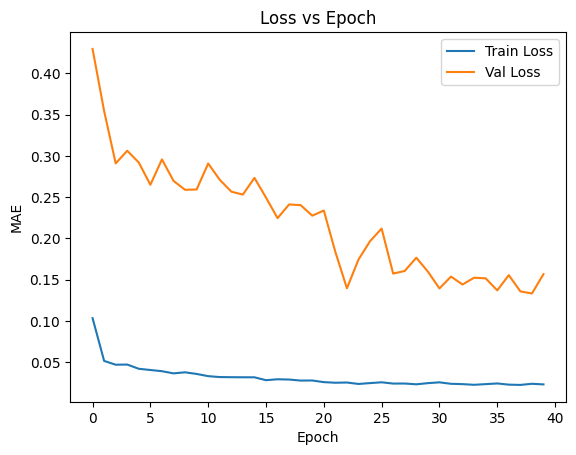

In [ ]:
plt.plot(history_bmri.history['loss'], label='Train Loss')
plt.plot(history_bmri.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [ ]:
y_pred_bmri = model_bmri.predict(X_test_bmri[..., np.newaxis]).flatten()
scaler_bmri = scalers['BMRI']
y_pred_unscaled_bmri = scaler_bmri.inverse_transform(y_pred_bmri.reshape(-1, 1)).flatten()
y_test_unscaled_bmri = scaler_bmri.inverse_transform(y_test_bmri.reshape(-1, 1)).flatten()

mae_bmri = mean_absolute_error(y_test_unscaled_bmri, y_pred_unscaled_bmri)
rmse_bmri = np.sqrt(mean_squared_error(y_test_unscaled_bmri, y_pred_unscaled_bmri))
mape_bmri = mean_absolute_percentage_error(y_test_unscaled_bmri, y_pred_unscaled_bmri) * 100

print('MAE Data Test BMRI : ', mae_bmri)
print('RMSE Data Test BMRI: ', rmse_bmri)
print('MAPE Data Test BMRI: ', mape_bmri)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
MAE Data Test BMRI :  338.4015657795009
RMSE Data Test BMRI:  403.6316055256724
MAPE Data Test BMRI:  5.747671835540613


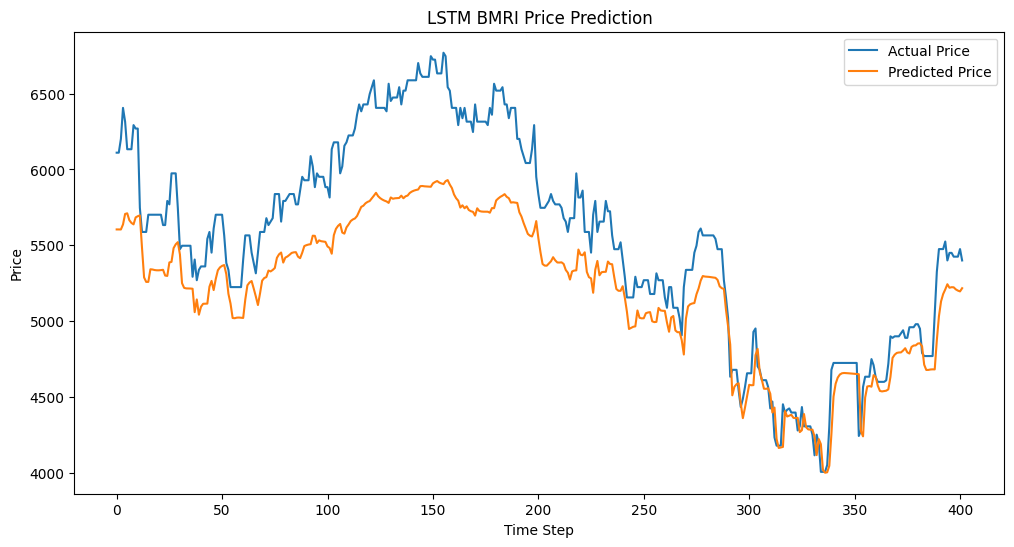

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled_bmri, label='Actual Price')
plt.plot(y_pred_unscaled_bmri, label='Predicted Price')
plt.title('LSTM BMRI Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
time_span = {'1d': 1, '1w': 7, '1m': 30, '3m': 90, '6m': 180}
recent_data_bmri = data_bmri[-365:]

pred_dict_bmri = {}
for label, steps in time_span.items():
    X = recent_data_bmri.copy()
    for _ in range(steps):
        x_input = X[-365:].reshape(1, 365, 1)
        next_pred = model_bmri.predict(x_input, verbose=0)[0, 0]
        X = np.append(X, next_pred)

    # Ambil nilai terakhir dan kembalikan ke skala asli
    unscaled_pred_bmri = scaler_bmri.inverse_transform([[X[-1]]])[0, 0]
    pred_dict_bmri[label] = float(unscaled_pred_bmri)

pred_dict_bmri

{'1d': 5186.498875524884,
 '1w': 4467.419966026233,
 '1m': 4237.297747725639,
 '3m': 3992.542553895918,
 '6m': 3902.2223772362304}

## DSSA

In [ ]:
window_size = 30
horizon = 1

data_dssa = df_scaled['DSSA'].values
X_train_dssa, y_train_dssa, X_val_dssa, y_val_dssa, X_test_dssa, y_test_dssa = split_data(data_dssa, window_size, horizon)

model_dssa = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

model_dssa.compile(optimizer='adam', loss='mae', metrics=['mape'])

model_dssa.summary()
print("Model input shape:", model_dssa.input_shape)
print("Model output shape:", model_dssa.output_shape)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (None, 30, 1)
Model output shape: (None, 1)


In [ ]:
history_dssa = model_dssa.fit(X_train_dssa[..., np.newaxis], y_train_dssa,
              validation_data=(X_val_dssa[..., np.newaxis], y_val_dssa),
              epochs=40)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 0.1060 - mape: 24.1239 - val_loss: 0.0387 - val_mape: 78.7814
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0309 - mape: 7.0277 - val_loss: 0.0362 - val_mape: 74.7724
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0293 - mape: 6.7878 - val_loss: 0.0292 - val_mape: 64.2713
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0280 - mape: 6.3993 - val_loss: 0.0373 - val_mape: 72.5391
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0272 - mape: 6.2249 - val_loss: 0.0319 - val_mape: 67.3363
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0279 - mape: 6.4114 - val_loss: 0.0294 - val_mape: 61.9744
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0244 - mape: 5.6072 - val_loss: 0.0258 - val_mape: 58.8994
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0249 - mape: 5.7728 - val_loss: 0.0286 - val_mape: 60.4730
Epoch 9/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 6

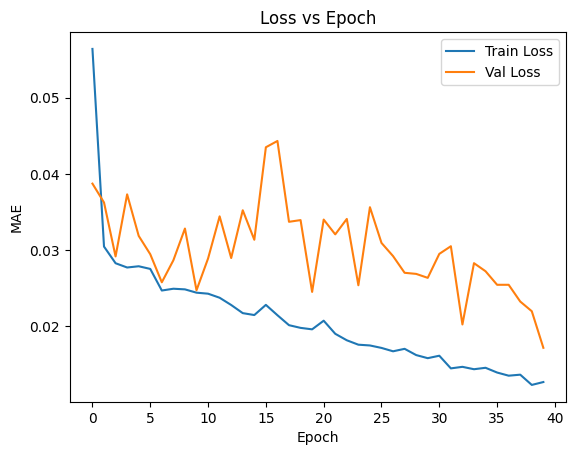

In [ ]:
plt.plot(history_dssa.history['loss'], label='Train Loss')
plt.plot(history_dssa.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [ ]:
y_pred_dssa = model_dssa.predict(X_test_dssa[..., np.newaxis]).flatten()
scaler_dssa = scalers['DSSA']
y_pred_unscaled_dssa = scaler_dssa.inverse_transform(y_pred_dssa.reshape(-1, 1)).flatten()
y_test_unscaled_dssa = scaler_dssa.inverse_transform(y_test_dssa.reshape(-1, 1)).flatten()

mae_dssa = mean_absolute_error(y_test_unscaled_dssa, y_pred_unscaled_dssa)
rmse_dssa = np.sqrt(mean_squared_error(y_test_unscaled_dssa, y_pred_unscaled_dssa))
mape_dssa = mean_absolute_percentage_error(y_test_unscaled_dssa, y_pred_unscaled_dssa) * 100

print('MAE Data Test DSSA : ', mae_dssa)
print('RMSE Data Test DSSA: ', rmse_dssa)
print('MAPE Data Test DSSA: ', mape_dssa)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
MAE Data Test DSSA :  1222.5140216884329
RMSE Data Test DSSA:  1749.824673546307
MAPE Data Test DSSA:  3.5629994882026623


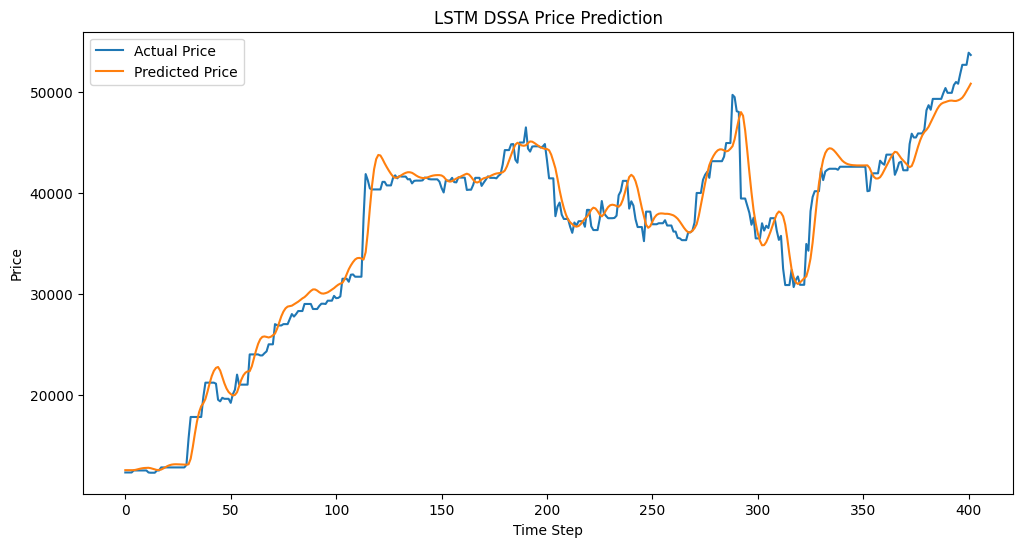

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled_dssa, label='Actual Price')
plt.plot(y_pred_unscaled_dssa, label='Predicted Price')
plt.title('LSTM DSSA Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
time_span = {'1d': 1, '1w': 7, '1m': 30, '3m': 90, '6m': 180}
recent_data_dssa = data_dssa[-365:]

pred_dict_dssa = {}
for label, steps in time_span.items():
    X = recent_data_dssa.copy()
    for _ in range(steps):
        x_input = X[-365:].reshape(1, 365, 1)
        next_pred = model_dssa.predict(x_input, verbose=0)[0, 0]
        X = np.append(X, next_pred)

    # Ambil nilai terakhir dan kembalikan ke skala asli
    unscaled_pred_dssa = scaler_dssa.inverse_transform([[X[-1]]])[0, 0]
    pred_dict_dssa[label] = float(unscaled_pred_dssa)

pred_dict_dssa

{'1d': 51476.02441363655,
 '1w': 50205.89426505055,
 '1m': 44443.8073547156,
 '3m': 45302.381267968274,
 '6m': 45407.74808905023}

## TLKM

In [ ]:
window_size = 30
horizon = 1

data_tlkm = df_scaled['TLKM'].values
X_train_tlkm, y_train_tlkm, X_val_tlkm, y_val_tlkm, X_test_tlkm, y_test_tlkm = split_data(data_tlkm, window_size, horizon)

model_tlkm = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1)
])

model_tlkm.compile(optimizer='adam', loss='mae', metrics=['mape'])

model_tlkm.summary()
print("Model input shape:", model_tlkm.input_shape)
print("Model output shape:", model_tlkm.output_shape)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (None, 30, 1)
Model output shape: (None, 1)


In [ ]:
history_tlkm = model_tlkm.fit(X_train_tlkm[..., np.newaxis], y_train_tlkm,
              validation_data=(X_val_tlkm[..., np.newaxis], y_val_tlkm),
              epochs=40)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.3441 - mape: 102.6736 - val_loss: 0.1300 - val_mape: 19.2126
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1450 - mape: 65.8033 - val_loss: 0.1266 - val_mape: 16.2425
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1288 - mape: 56.7584 - val_loss: 0.1076 - val_mape: 14.7661
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1175 - mape: 51.0078 - val_loss: 0.0960 - val_mape: 13.3417
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.1075 - mape: 60.0601 - val_loss: 0.0902 - val_mape: 12.3989
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1053 - mape: 52.3102 - val_loss: 0.0899 - val_mape: 12.3711
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1015 - mape: 46.5145 - val_loss: 0.0788 - val_mape: 10.6104
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0940 - mape: 33.6902 - val_loss: 0.0753 - val_mape: 9.6722
Epoch 9/40
59/59 ━━━━━━━━━━━━━━━

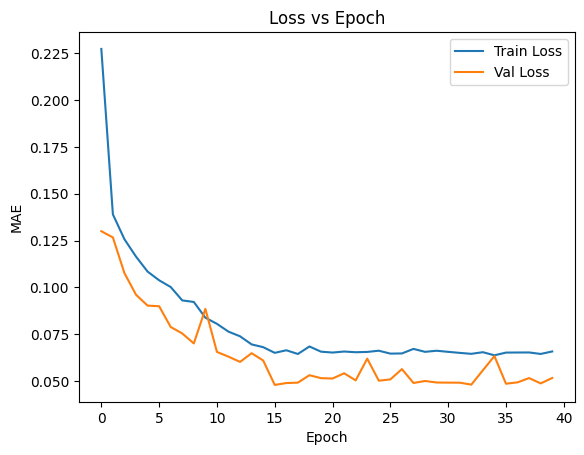

In [ ]:
plt.plot(history_tlkm.history['loss'], label='Train Loss')
plt.plot(history_tlkm.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [ ]:
y_pred_tlkm = model_tlkm.predict(X_test_tlkm[..., np.newaxis]).flatten()
scaler_tlkm = scalers['TLKM']
y_pred_unscaled_tlkm = scaler_tlkm.inverse_transform(y_pred_tlkm.reshape(-1, 1)).flatten()
y_test_unscaled_tlkm = scaler_tlkm.inverse_transform(y_test_tlkm.reshape(-1, 1)).flatten()

mae_tlkm = mean_absolute_error(y_test_unscaled_tlkm, y_pred_unscaled_tlkm)
rmse_tlkm = np.sqrt(mean_squared_error(y_test_unscaled_tlkm, y_pred_unscaled_tlkm))
mape_tlkm = mean_absolute_percentage_error(y_test_unscaled_tlkm, y_pred_unscaled_tlkm) * 100

print('MAE Data Test TLKM : ', mae_tlkm)
print('RMSE Data Test TLKM: ', rmse_tlkm)
print('MAPE Data Test TLKM: ', mape_tlkm)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
MAE Data Test TLKM :  30.809584888059703
RMSE Data Test TLKM:  47.913320872598185
MAPE Data Test TLKM:  1.1184426060001034


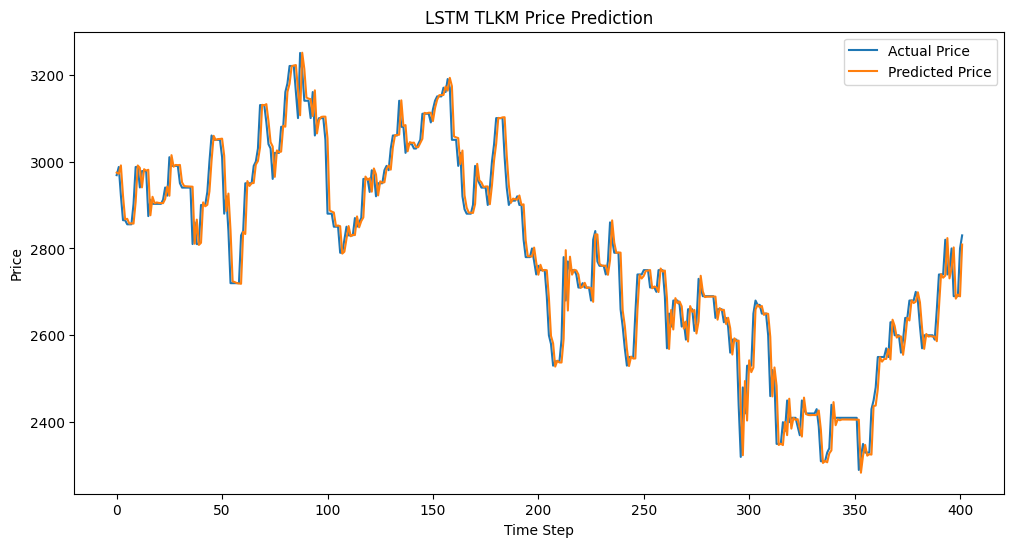

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled_tlkm, label='Actual Price')
plt.plot(y_pred_unscaled_tlkm, label='Predicted Price')
plt.title('LSTM TLKM Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
time_span = {'1d': 1, '1w': 7, '1m': 30, '3m': 90, '6m': 180}
recent_data_tlkm = data_tlkm[-365:]

pred_dict_tlkm = {}
for label, steps in time_span.items():
    X = recent_data_tlkm.copy()
    for _ in range(steps):
        x_input = X[-365:].reshape(1, 365, 1)
        next_pred = model_tlkm.predict(x_input, verbose=0)[0, 0]
        X = np.append(X, next_pred)

    # Ambil nilai terakhir dan kembalikan ke skala asli
    unscaled_pred_tlkm = scaler_tlkm.inverse_transform([[X[-1]]])[0, 0]
    pred_dict_tlkm[label] = float(unscaled_pred_tlkm)

pred_dict_tlkm

{'1d': 2825.0159420442424,
 '1w': 2819.7401952392306,
 '1m': 2827.166315734704,
 '3m': 2868.9406470430913,
 '6m': 3014.808146106985}

## ASII

In [ ]:
window_size = 30
horizon = 1

data_asii = df_scaled['ASII'].values
X_train_asii, y_train_asii, X_val_asii, y_val_asii, X_test_asii, y_test_asii = split_data(data_asii, window_size, horizon)

model_asii = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1)
])

model_asii.compile(optimizer='adam', loss='mae', metrics=['mape'])

model_asii.summary()
print("Model input shape:", model_asii.input_shape)
print("Model output shape:", model_asii.output_shape)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (None, 30, 1)
Model output shape: (None, 1)


In [ ]:
history_asii = model_asii.fit(X_train_asii[..., np.newaxis], y_train_asii,
              validation_data=(X_val_asii[..., np.newaxis], y_val_asii),
              epochs=40)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.4093 - mape: 96.7946 - val_loss: 0.1458 - val_mape: 81.0826
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1541 - mape: 66.2565 - val_loss: 0.1176 - val_mape: 95.7045
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1477 - mape: 62.6634 - val_loss: 0.1006 - val_mape: 69.7709
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1297 - mape: 52.0122 - val_loss: 0.1240 - val_mape: 69.0242
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1278 - mape: 48.2170 - val_loss: 0.1003 - val_mape: 57.2292
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1317 - mape: 45.9493 - val_loss: 0.0899 - val_mape: 56.4382
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1159 - mape: 45.6957 - val_loss: 0.0801 - val_mape: 48.0938
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1122 - mape: 47.8845 - val_loss: 0.0798 - val_mape: 57.9028
Epoch 9/40
59/59 ━━━━━━━━━━━━━━━

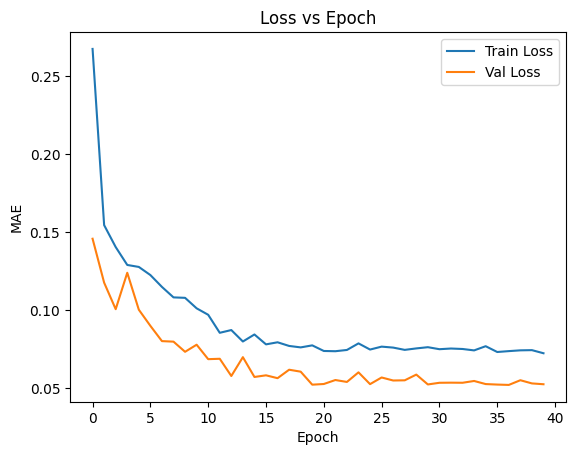

In [ ]:
plt.plot(history_asii.history['loss'], label='Train Loss')
plt.plot(history_asii.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [ ]:
y_pred_asii = model_asii.predict(X_test_asii[..., np.newaxis]).flatten()
scaler_asii = scalers['ASII']
y_pred_unscaled_asii = scaler_asii.inverse_transform(y_pred_asii.reshape(-1, 1)).flatten()
y_test_unscaled_asii = scaler_asii.inverse_transform(y_test_asii.reshape(-1, 1)).flatten()

mae_asii = mean_absolute_error(y_test_unscaled_asii, y_pred_unscaled_asii)
rmse_asii = np.sqrt(mean_squared_error(y_test_unscaled_asii, y_pred_unscaled_asii))
mape_asii = mean_absolute_percentage_error(y_test_unscaled_asii, y_pred_unscaled_asii) * 100

print('MAE Data Test ASII : ', mae_asii)
print('RMSE Data Test ASII: ', rmse_asii)
print('MAPE Data Test ASII: ', mape_asii)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
MAE Data Test ASII :  39.544032158543224
RMSE Data Test ASII:  63.43001914959029
MAPE Data Test ASII:  0.883806103604817


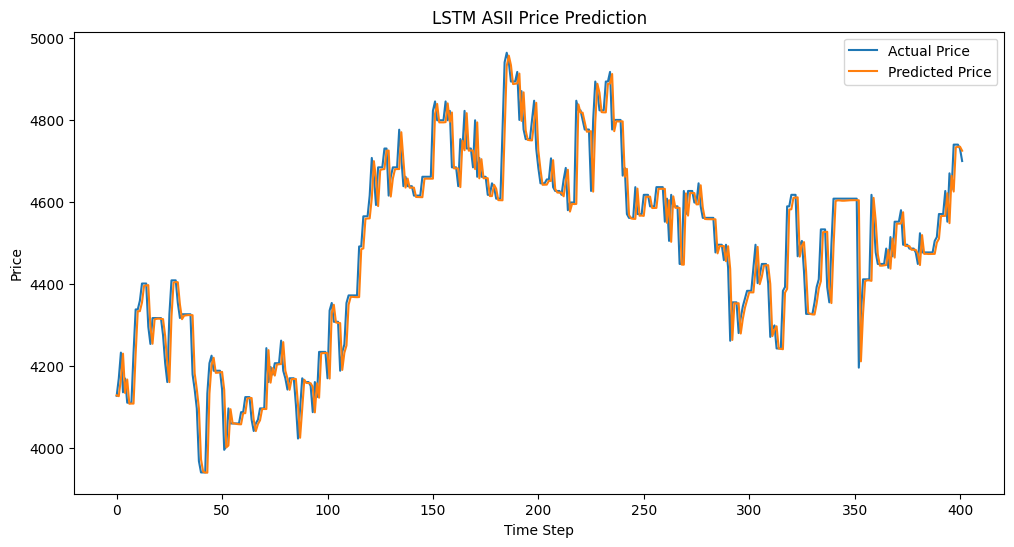

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled_asii, label='Actual Price')
plt.plot(y_pred_unscaled_asii, label='Predicted Price')
plt.title('LSTM ASII Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
time_span = {'1d': 1, '1w': 7, '1m': 30, '3m': 90, '6m': 180}
recent_data_asii = data_asii[-365:]

pred_dict_asii = {}
for label, steps in time_span.items():
    X = recent_data_asii.copy()
    for _ in range(steps):
        x_input = X[-365:].reshape(1, 365, 1)
        next_pred = model_asii.predict(x_input, verbose=0)[0, 0]
        X = np.append(X, next_pred)

    # Ambil nilai terakhir dan kembalikan ke skala asli
    unscaled_pred_asii = scaler_asii.inverse_transform([[X[-1]]])[0, 0]
    pred_dict_asii[label] = float(unscaled_pred_asii)

pred_dict_asii

{'1d': 4695.828577130124,
 '1w': 4673.943468086266,
 '1m': 4586.185131184755,
 '3m': 4391.0599913139795,
 '6m': 4173.014733999371}

## BBNI

In [ ]:
window_size = 30
horizon = 1

data_bbni = df_scaled['BBNI'].values
X_train_bbni, y_train_bbni, X_val_bbni, y_val_bbni, X_test_bbni, y_test_bbni = split_data(data_bbni, window_size, horizon)

model_bbni = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1)
])

model_bbni.compile(optimizer='adam', loss='mae', metrics=['mape'])

model_bbni.summary()
print("Model input shape:", model_bbni.input_shape)
print("Model output shape:", model_bbni.output_shape)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (None, 30, 1)
Model output shape: (None, 1)


In [ ]:
history_bbni = model_bbni.fit(X_train_bbni[..., np.newaxis], y_train_bbni,
              validation_data=(X_val_bbni[..., np.newaxis], y_val_bbni),
              epochs=40)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.2474 - mape: 109.9252 - val_loss: 0.3727 - val_mape: 27.9439
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0936 - mape: 74.2561 - val_loss: 0.2966 - val_mape: 22.0204
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0830 - mape: 86.6478 - val_loss: 0.2492 - val_mape: 18.0920
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0730 - mape: 97.5779 - val_loss: 0.2477 - val_mape: 18.3344
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0687 - mape: 82.3894 - val_loss: 0.1877 - val_mape: 13.0258
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0709 - mape: 114.2816 - val_loss: 0.1749 - val_mape: 12.0449
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0639 - mape: 82.0948 - val_loss: 0.1807 - val_mape: 13.0232
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0584 - mape: 96.8038 - val_loss: 0.1593 - val_mape: 11.3015
Epoch 9/40
59/59 ━━━━━━━━━━━━━

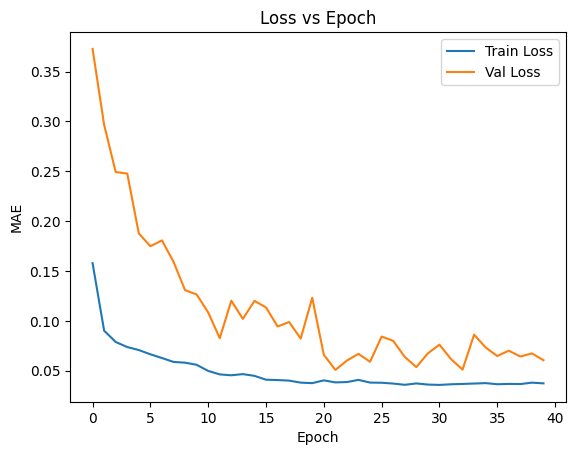

In [ ]:
plt.plot(history_bbni.history['loss'], label='Train Loss')
plt.plot(history_bbni.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [ ]:
y_pred_bbni = model_bbni.predict(X_test_bbni[..., np.newaxis]).flatten()
scaler_bbni = scalers['BBNI']
y_pred_unscaled_bbni = scaler_bbni.inverse_transform(y_pred_bbni.reshape(-1, 1)).flatten()
y_test_unscaled_bbni = scaler_bbni.inverse_transform(y_test_bbni.reshape(-1, 1)).flatten()

mae_bbni = mean_absolute_error(y_test_unscaled_bbni, y_pred_unscaled_bbni)
rmse_bbni = np.sqrt(mean_squared_error(y_test_unscaled_bbni, y_pred_unscaled_bbni))
mape_bbni = mean_absolute_percentage_error(y_test_unscaled_bbni, y_pred_unscaled_bbni) * 100

print('MAE Data Test BBNI : ', mae_bbni)
print('RMSE Data Test BBNI: ', rmse_bbni)
print('MAPE Data Test BBNI: ', mape_bbni)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
MAE Data Test BBNI :  73.02645707011816
RMSE Data Test BBNI:  100.72657250193754
MAPE Data Test BBNI:  1.6354089806869123


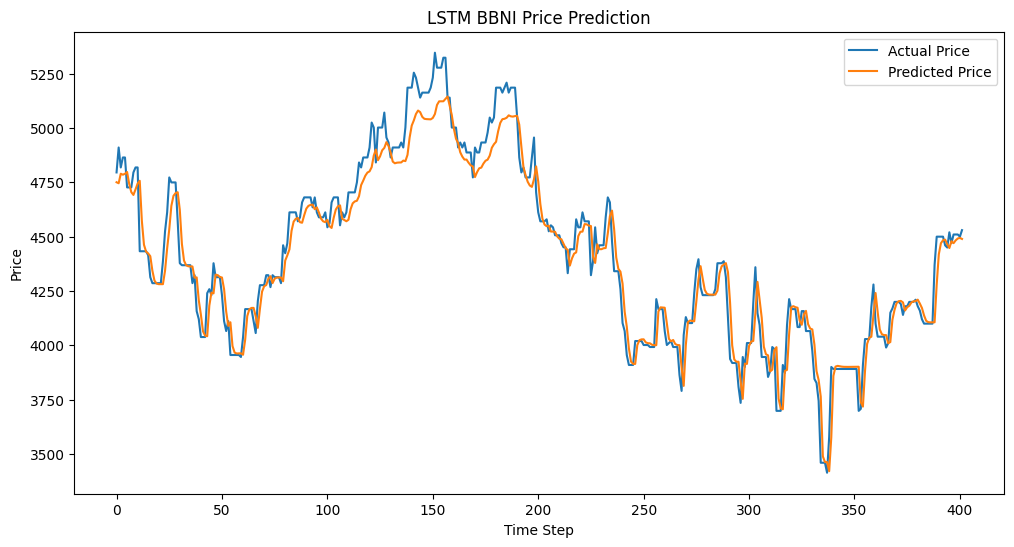

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled_bbni, label='Actual Price')
plt.plot(y_pred_unscaled_bbni, label='Predicted Price')
plt.title('LSTM BBNI Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
time_span = {'1d': 1, '1w': 7, '1m': 30, '3m': 90, '6m': 180}
recent_data_bbni = data_bbni[-365:]

pred_dict_bbni = {}
for label, steps in time_span.items():
    X = recent_data_bbni.copy()
    for _ in range(steps):
        x_input = X[-365:].reshape(1, 365, 1)
        next_pred = model_bbni.predict(x_input, verbose=0)[0, 0]
        X = np.append(X, next_pred)

    # Ambil nilai terakhir dan kembalikan ke skala asli
    unscaled_pred_bbni = scaler_bbni.inverse_transform([[X[-1]]])[0, 0]
    pred_dict_bbni[label] = float(unscaled_pred_bbni)

pred_dict_bbni

{'1d': 4502.940984995167,
 '1w': 4454.08643553622,
 '1m': 4339.935577887296,
 '3m': 4282.098127316179,
 '6m': 4276.759953159192}

## ICBP

In [ ]:
window_size = 30
horizon = 1

data_icbp = df_scaled['ICBP'].values
X_train_icbp, y_train_icbp, X_val_icbp, y_val_icbp, X_test_icbp, y_test_icbp = split_data(data_icbp, window_size, horizon)

model_icbp = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1)
])

model_icbp.compile(optimizer='adam', loss='mae', metrics=['mape'])

model_icbp.summary()
print("Model input shape:", model_icbp.input_shape)
print("Model output shape:", model_icbp.output_shape)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (None, 30, 1)
Model output shape: (None, 1)


In [ ]:
history_icbp = model_icbp.fit(X_train_icbp[..., np.newaxis], y_train_icbp,
              validation_data=(X_val_icbp[..., np.newaxis], y_val_icbp),
              epochs=40)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.3185 - mape: 83.1066 - val_loss: 0.1848 - val_mape: 21.2251
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1156 - mape: 58.5578 - val_loss: 0.1224 - val_mape: 16.6197
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1005 - mape: 56.0693 - val_loss: 0.1336 - val_mape: 17.8884
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0947 - mape: 65.2681 - val_loss: 0.1191 - val_mape: 16.0743
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0855 - mape: 42.8557 - val_loss: 0.1094 - val_mape: 15.5533
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0838 - mape: 37.6663 - val_loss: 0.1033 - val_mape: 14.5680
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0780 - mape: 53.6450 - val_loss: 0.1030 - val_mape: 14.6142
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0760 - mape: 41.7238 - val_loss: 0.0928 - val_mape: 13.1125
Epoch 9/40
59/59 ━━━━━━━━━━━━━━━

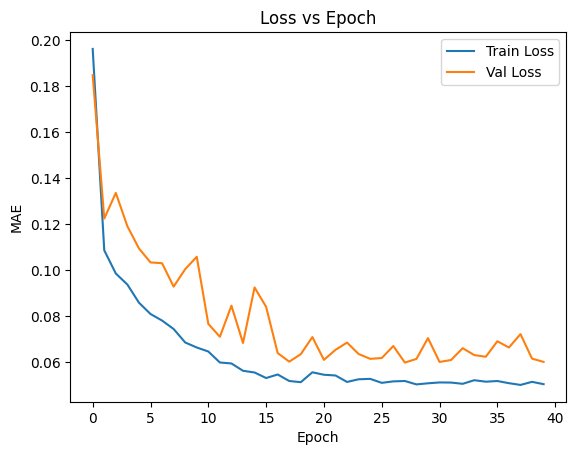

In [ ]:
plt.plot(history_icbp.history['loss'], label='Train Loss')
plt.plot(history_icbp.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [ ]:
y_pred_icbp = model_icbp.predict(X_test_icbp[..., np.newaxis]).flatten()
scaler_icbp = scalers['ICBP']
y_pred_unscaled_icbp = scaler_icbp.inverse_transform(y_pred_icbp.reshape(-1, 1)).flatten()
y_test_unscaled_icbp = scaler_icbp.inverse_transform(y_test_icbp.reshape(-1, 1)).flatten()

mae_icbp = mean_absolute_error(y_test_unscaled_icbp, y_pred_unscaled_icbp)
rmse_icbp = np.sqrt(mean_squared_error(y_test_unscaled_icbp, y_pred_unscaled_icbp))
mape_icbp = mean_absolute_percentage_error(y_test_unscaled_icbp, y_pred_unscaled_icbp) * 100

print('MAE Data Test ICBP : ', mae_icbp)
print('RMSE Data Test ICBP: ', rmse_icbp)
print('MAPE Data Test ICBP: ', mape_icbp)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
MAE Data Test ICBP :  111.84435488572761
RMSE Data Test ICBP:  167.51271980973235
MAPE Data Test ICBP:  0.9989086780801043


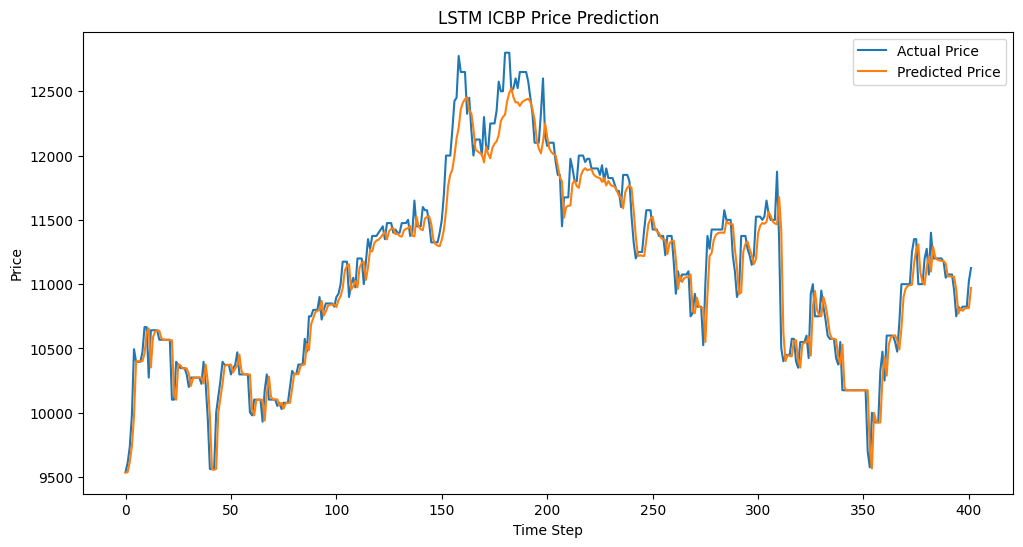

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled_icbp, label='Actual Price')
plt.plot(y_pred_unscaled_icbp, label='Predicted Price')
plt.title('LSTM ICBP Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
time_span = {'1d': 1, '1w': 7, '1m': 30, '3m': 90, '6m': 180}
recent_data_icbp = data_icbp[-365:]

pred_dict_icbp = {}
for label, steps in time_span.items():
    X = recent_data_icbp.copy()
    for _ in range(steps):
        x_input = X[-365:].reshape(1, 365, 1)
        next_pred = model_icbp.predict(x_input, verbose=0)[0, 0]
        X = np.append(X, next_pred)

    # Ambil nilai terakhir dan kembalikan ke skala asli
    unscaled_pred_icbp = scaler_icbp.inverse_transform([[X[-1]]])[0, 0]
    pred_dict_icbp[label] = float(unscaled_pred_icbp)

pred_dict_icbp

{'1d': 11072.901036091362,
 '1w': 11017.379804318562,
 '1m': 10817.023502058973,
 '3m': 10570.702705269307,
 '6m': 10425.899865210518}

## All at once

In [ ]:
models = {}
history = {}
window_size = 30
horizon = 1

for ticker in tickers:
    print(f"Training model for {ticker}...")

    data = df_scaled[ticker].values
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(data, window_size, horizon)

    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
        LSTM(32),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mae', metrics=['mape'])
    h = model.fit(X_train[..., np.newaxis], y_train,
                  validation_data=(X_val[..., np.newaxis], y_val),
                  epochs=40)

    models[ticker] = model
    history[ticker] = h.history

Training model for BBCA...
Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.2847 - mape: 70.7246 - val_loss: 0.2860 - val_mape: 25.2877
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0542 - mape: 43.2947 - val_loss: 0.1124 - val_mape: 9.6435
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0540 - mape: 43.6916 - val_loss: 0.0812 - val_mape: 6.9634
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0454 - mape: 36.8128 - val_loss: 0.0962 - val_mape: 8.3155
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0430 - mape: 30.3724 - val_loss: 0.0838 - val_mape: 7.1919
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0425 - mape: 27.2310 - val_loss: 0.0797 - val_mape: 6.8706
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0446 - mape: 33.5154 - val_loss: 0.1027 - val_mape: 8.8359
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0405 - mape: 29.6579 - val_loss: 0.1106 - val_mape: 9.5687
Epoch 9/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step

In [ ]:
results = {}

for ticker in tickers:
    print(f"Evaluating model for {ticker}")
    model = models[ticker]
    data = df_scaled[ticker].values
    _, _, _, _, X_test, y_test = split_data(data, window_size, horizon)
    y_pred = model.predict(X_test[..., np.newaxis]).flatten()

    # Unscale hasil prediksi dan aktual
    scaler = scalers[ticker]
    y_pred_unscaled = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
    mape = mean_absolute_percentage_error(y_test_unscaled, y_pred_unscaled) * 100

    results[ticker] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

pd.DataFrame(results).T

Evaluating model for BBCA
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Evaluating model for BYAN
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Evaluating model for TPIA
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Evaluating model for BBRI
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Evaluating model for BMRI
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Evaluating model for DSSA
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Evaluating model for TLKM
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Evaluating model for ASII
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Evaluating model for BBNI
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Evaluating model for ICBP
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


,MAE,RMSE,MAPE
BBCA,164.622272,199.671520,1.723685
BYAN,388.668639,488.557411,2.093574
TPIA,2738.204640,2894.910078,32.364309
BBRI,50.652966,75.413704,1.235648
BMRI,190.816073,239.426263,3.252560
DSSA,12186.344554,13717.262126,31.014842
TLKM,30.244482,47.226597,1.097131
ASII,39.557342,63.211657,0.886017
BBNI,82.093864,107.496748,1.820741
ICBP,119.396045,172.194786,1.063504


In [ ]:
futures = {'1d': 1, '1w': 7, '1m': 30, '3m': 90, '6m': 180}
predictions = {}

for ticker in tickers:
    print(f"Inferencing for {ticker}...")
    model = models[ticker]
    data = df_scaled[ticker].values
    recent_data = data[-window_size:]

    pred_dict = {}
    for label, steps in futures.items():
        X = recent_data.copy()
        for _ in range(steps):
            x_input = X[-window_size:].reshape(1, window_size, 1)
            next_pred = model.predict(x_input, verbose=0)[0, 0]
            X = np.append(X, next_pred)

        # Ambil nilai terakhir dan kembalikan ke skala asli
        unscaled_pred = scalers[ticker].inverse_transform([[X[-1]]])[0, 0]
        pred_dict[label] = unscaled_pred

    predictions[ticker] = pred_dict

pd.DataFrame(predictions)

Inferencing for BBCA...
Inferencing for BYAN...
Inferencing for TPIA...
Inferencing for BBRI...
Inferencing for BMRI...
Inferencing for DSSA...
Inferencing for TLKM...
Inferencing for ASII...
Inferencing for BBNI...
Inferencing for ICBP...


,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
1d,9372.081243,19536.609107,5699.727659,4343.370216,5310.913658,26614.748343,2829.087375,4703.497309,4470.484972,11059.745705
1w,8958.543082,18886.150076,5357.189158,4264.687792,4951.371508,25743.654351,2833.605046,4722.968428,4291.226998,10901.767930
1m,8080.775097,18266.321070,3672.550642,4079.803476,4642.670004,16446.576450,2842.855833,4770.134692,3872.829064,10506.759613
3m,7508.981074,18304.850627,2536.641387,3897.400149,4570.441697,10832.105136,2857.930273,4873.247989,3561.717571,10009.272075
6m,7188.509392,18304.321018,2111.480230,3765.499441,4566.988394,8329.643970,2866.429347,4987.429309,3492.916379,9701.175391
